# Things to do:

* Windowing with pandas. 
* create sequence of microbusiness_density as lable
* scale the feature. 
* As other guys says,small population county data is just a noise, so I will test with the bigger population county. 
* Explore GroupKFold scikit-learn

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import multiprocessing as mp
import pandas as pd
import numpy as np
from functools import partial
import random

from helper_functions import *

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


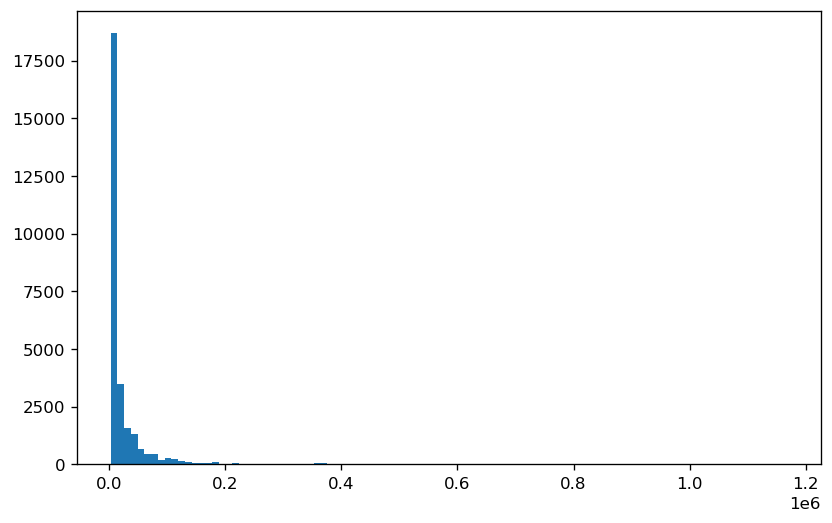

In [4]:
plt.hist(train.active, bins=100, range=(2500, train.active.max()));

In [5]:
train.active.mean()

6442.858217805586

In [6]:
train.active.max()

1167744

In [7]:
# 728 county is larger than 2500 active. 
len(train[train.active > 2500]) / 39

728.5384615384615

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [9]:
sorted_train = train.sort_values('active', ascending=False)
IDS = sorted_train.cfips.unique()[:10]

In [10]:
# I will experiment with the biggest population county
c = train.loc[train.active == train.active.max()]['cfips'].values[0]
df = train[train.cfips == c].reset_index()[['cfips', 'active', 'microbusiness_density', ]]
# add window columns
HORIZON = 8
WINDOW = 9

for i in range(WINDOW):
    df[f'microbusiness_density+{i+1}'] = df['microbusiness_density'].shift(periods=i+1)
df.head(10)

,cfips,active,microbusiness_density,microbusiness_density+1,microbusiness_density+2,microbusiness_density+3,microbusiness_density+4,microbusiness_density+5,microbusiness_density+6,microbusiness_density+7,microbusiness_density+8,microbusiness_density+9
0,6037,1119817,14.297710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6037,1122271,14.329043,14.297710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6037,1128104,14.403519,14.329043,14.297710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6037,1141159,14.570203,14.403519,14.329043,14.297710,NaN,NaN,NaN,NaN,NaN,NaN
4,6037,1140149,14.557307,14.570203,14.403519,14.329043,14.297710,NaN,NaN,NaN,NaN,NaN
5,6037,1142034,14.545367,14.557307,14.570203,14.403519,14.329043,14.297710,NaN,NaN,NaN,NaN
6,6037,1131067,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043,14.297710,NaN,NaN,NaN
7,6037,1136933,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043,14.297710,NaN,NaN
8,6037,1160868,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043,14.297710,NaN
9,6037,1167744,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043,14.29771


In [11]:
# create sequenced label
windows, labels = make_windows(df['microbusiness_density'].values, window_size=(WINDOW-HORIZON)+1, horizon=HORIZON)
len(labels), labels[0] # first lable is the 9th of the 

(30,
 array([14.403519, 14.570203, 14.557307, 14.545367, 14.405687, 14.480399,
        14.785244, 14.872819]))

In [12]:
df = df[WINDOW:]

In [13]:
df

,cfips,active,microbusiness_density,microbusiness_density+1,microbusiness_density+2,microbusiness_density+3,microbusiness_density+4,microbusiness_density+5,microbusiness_density+6,microbusiness_density+7,microbusiness_density+8,microbusiness_density+9
9,6037,1167744,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043,14.297710
10,6037,1079649,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043
11,6037,1089596,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519
12,6037,1096214,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203
13,6037,1098345,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307
14,6037,1106294,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367
15,6037,1104834,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687
16,6037,1106937,14.098359,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399
17,6037,1107416,14.077065,14.098359,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244
18,6037,1084609,13.787151,14.077065,14.098359,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819


In [14]:
df = df.reset_index().drop('index', axis=1)

In [15]:
df

,cfips,active,microbusiness_density,microbusiness_density+1,microbusiness_density+2,microbusiness_density+3,microbusiness_density+4,microbusiness_density+5,microbusiness_density+6,microbusiness_density+7,microbusiness_density+8,microbusiness_density+9
0,6037,1167744,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043,14.297710
1,6037,1079649,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519,14.329043
2,6037,1089596,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203,14.403519
3,6037,1096214,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307,14.570203
4,6037,1098345,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367,14.557307
5,6037,1106294,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687,14.545367
6,6037,1104834,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399,14.405687
7,6037,1106937,14.098359,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244,14.480399
8,6037,1107416,14.077065,14.098359,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819,14.785244
9,6037,1084609,13.787151,14.077065,14.098359,14.071574,14.090169,13.988928,13.961786,13.877498,13.750809,14.872819


In [16]:
# Set microbusiness_density sequence as label, and rest of the data as feature
X = df.drop(['cfips', 'microbusiness_density'], axis=1)
Y = labels
len(X), len(Y)

(30, 30)

In [17]:
# Scale feature
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [18]:
# Split train and test datast
train_data, test_data, train_labels, test_labels = make_train_test_split(X, Y, split_size=6)
len(train_data), len(test_data), len(train_labels), len(test_labels)

(24, 6, 24, 6)

In [19]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
                layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                layers.LSTM(128, activation="relu", return_sequences=True),
                layers.LSTM(128, activation="relu", return_sequences=True),
                layers.LSTM(128, activation="relu"),
                layers.Dense(8)
            ], name=f'lstm_model')

model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae', 'mse'])

model.fit(x=train_data, 
          y=train_labels, 
          epochs=500,
          batch_size=256, verbose=0)

In [20]:
# model = tf.keras.models.load_model('model_experiments\\lstm_model')
preds = make_preds(model, test_data)
results = evaluate_preds(test_labels, preds)

1/1 [==============================] - 0s 287ms/step


In [21]:
results

{'mae': 0.059761167,
 'mse': 0.008397933,
 'rmse': 0.091640234,
 'mape': 0.4173356}

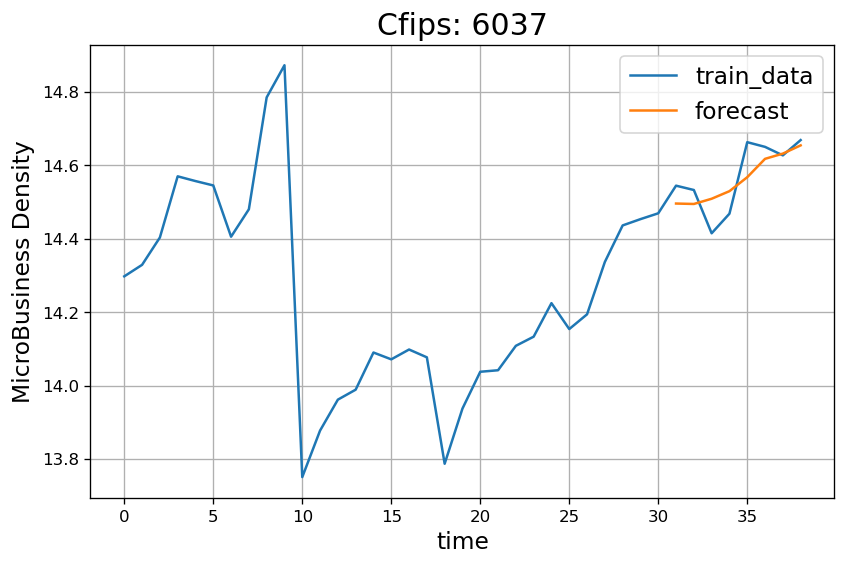

In [22]:
plot_time_series(c, np.arange(39).reshape((-1, 1)), train[train.cfips == c]['microbusiness_density'], label='train_data')
plot_time_series(c, np.arange(31, 39).reshape((-1, 1)), preds[-1], label='forecast')

### 1 test data

In [22]:
# Split train and test datast
train_data, test_data, train_labels, test_labels = make_train_test_split(X, Y, split_size=1)
len(train_data), len(test_data), len(train_labels), len(test_labels)

(30, 1, 30, 1)

In [23]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
                layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                layers.LSTM(128, activation="relu", return_sequences=True),
                layers.LSTM(128, activation="relu", return_sequences=True),
                layers.LSTM(128, activation="relu"),
                layers.Dense(8)
            ], name=f'lstm_model')

model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae', 'mse'])

model.fit(x=train_data, 
          y=train_labels, 
          epochs=500,
          batch_size=256, verbose=0)

# model = tf.keras.models.load_model('model_experiments\\lstm_model')
preds = make_preds(model, test_data)
results = evaluate_preds(test_labels, preds)

results

1/1 [==============================] - 0s 259ms/step


{'mae': 0.07213056, 'mse': 0.008358668, 'rmse': 0.09142575, 'mape': 0.49651912}

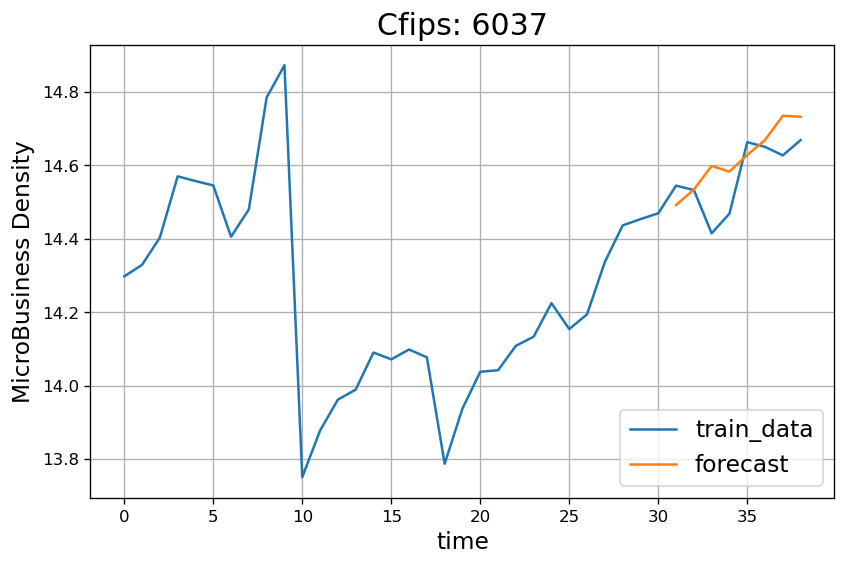

In [24]:
plot_time_series(c, np.arange(39).reshape((-1, 1)), train[train.cfips == c]['microbusiness_density'], label='train_data')
plot_time_series(c, np.arange(31, 39).reshape((-1, 1)), preds, label='forecast')

### Compare the result with original one

In [25]:
results = train_get_result(train, 8, 8, 500, 1, c)
results

1/1 [==============================] - 0s 258ms/step


(6037,
 14.469463,
 1137607,
 0.7406134,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([14.455349, 14.424229, 14.467102, 14.437155, 14.462073, 14.437769,
        14.646987, 14.518303], dtype=float32)>)

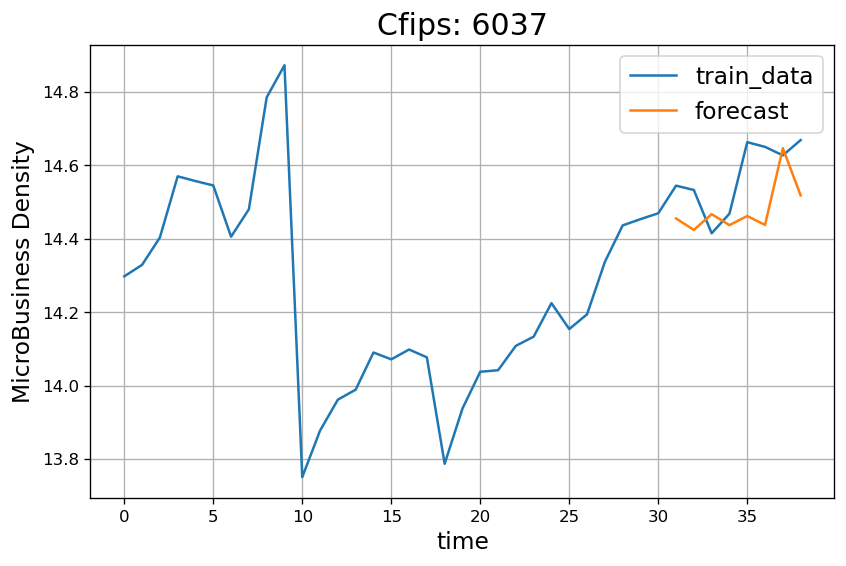

In [28]:
preds = results[4]
plot_time_series(c, np.arange(39).reshape((-1, 1)), train[train.cfips == c]['microbusiness_density'], label='train_data')
plot_time_series(c, np.arange(31, 39).reshape((-1, 1)), preds, label='forecast')

## Adding the feature gets better result than original way for test set. 

* Add validation set and see if it gets better

1/1 [==============================] - 0s 252ms/step
{'mae': 0.060834765, 'mse': 0.007059187, 'rmse': 0.08401897, 'mape': 0.42395285}


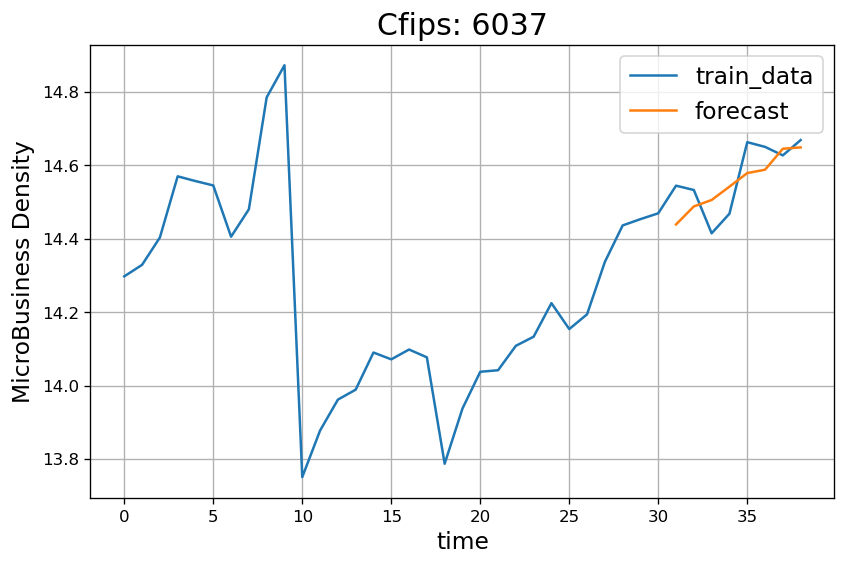

In [36]:
# Split train and test datast
train_data, test_data, train_labels, test_labels = make_train_test_split(X, Y, split_size=6)

tf.random.set_seed(42)

model = tf.keras.Sequential([
                layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                layers.LSTM(128, activation="relu", return_sequences=True),
                layers.LSTM(128, activation="relu", return_sequences=True),
                layers.LSTM(128, activation="relu"),
                layers.Dense(8)
            ], name=f'lstm_model')

model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae', 'mse'])

model.fit(x=train_data, 
          y=train_labels, 
          epochs=500,
          validation_data=(test_data, test_labels),
          batch_size=256, verbose=0)

preds = make_preds(model, test_data)
results = evaluate_preds(test_labels, preds)

print(results)

plot_time_series(c, np.arange(39).reshape((-1, 1)), train[train.cfips == c]['microbusiness_density'], label='train_data')
plot_time_series(c, np.arange(31, 39).reshape((-1, 1)), preds[-1], label='forecast')

## 10 lagest population county with 6 test dataset:

1/1 [==============================] - 0s 257ms/step
{'mae': 0.059761167, 'mse': 0.008397933, 'rmse': 0.091640234, 'mape': 0.4173356}
1/1 [==============================] - 0s 259ms/step
{'mae': 0.3198092, 'mse': 0.105598375, 'rmse': 0.32495904, 'mape': 2.1895964}
1/1 [==============================] - 0s 267ms/step
{'mae': 0.11402702, 'mse': 0.027579252, 'rmse': 0.16607001, 'mape': 0.34611762}
1/1 [==============================] - 0s 260ms/step
{'mae': 0.12764335, 'mse': 0.028635181, 'rmse': 0.16921933, 'mape': 0.7625859}
1/1 [==============================] - 0s 257ms/step
{'mae': 0.13764548, 'mse': 0.04078733, 'rmse': 0.20195873, 'mape': 0.6623318}
1/1 [==============================] - 0s 253ms/step
{'mae': 0.064940214, 'mse': 0.005285133, 'rmse': 0.07269892, 'mape': 0.37995234}
1/1 [==============================] - 0s 281ms/step
{'mae': 0.07232022, 'mse': 0.00622576, 'rmse': 0.07890349, 'mape': 0.82889664}
1/1 [==============================] - 0s 258ms/step
{'mae': 0.123147964,

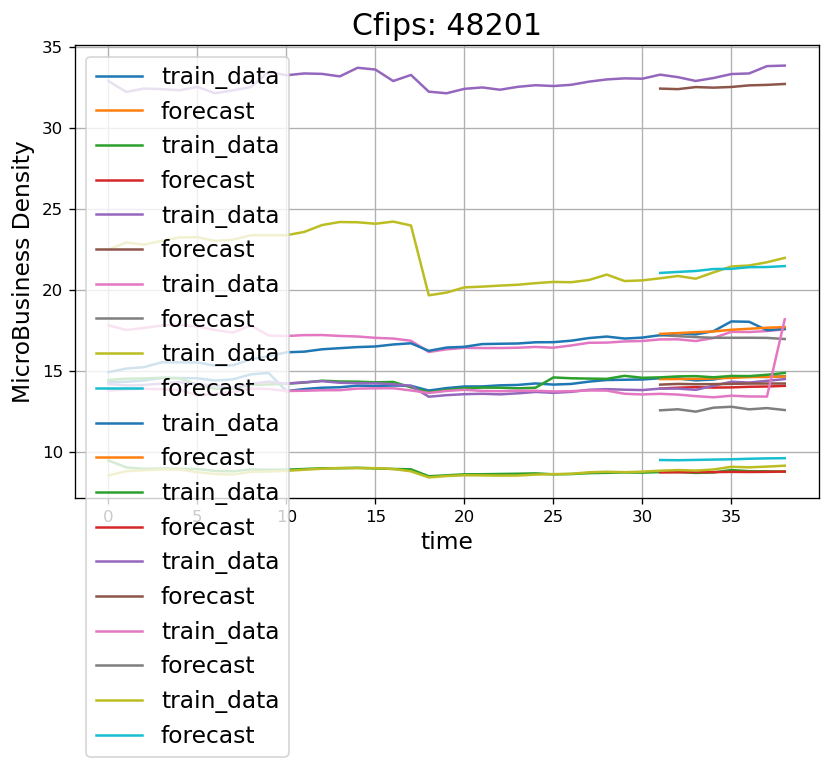

In [98]:
HORIZON = 8
WINDOW = 9

for cfips in IDS:
    c = cfips
    df = train[train.cfips == c].reset_index()[['cfips', 'active', 'microbusiness_density', ]]
    # add window columns
    for i in range(WINDOW):
        df[f'microbusiness_density+{i+1}'] = df['microbusiness_density'].shift(periods=i+1)

    # create sequenced label
    windows, labels = make_windows(df['microbusiness_density'].values, window_size=(WINDOW-HORIZON)+1, horizon=HORIZON)

    df = df[WINDOW:]

    df = df.reset_index().drop('index', axis=1)

    # Set microbusiness_density sequence as label, and rest of the data as feature
    X = df.drop(['cfips', 'microbusiness_density'], axis=1)
    Y = labels

    # Scale feature
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    train_data, test_data, train_labels, test_labels = make_train_test_split(X, Y, split_size=6)

    tf.random.set_seed(42)

    model = tf.keras.Sequential([
                    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                    layers.LSTM(128, activation="relu", return_sequences=True),
                    layers.LSTM(128, activation="relu", return_sequences=True),
                    layers.LSTM(128, activation="relu"),
                    layers.Dense(8)
                ], name=f'lstm_model')

    model.compile(loss='mae', 
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['mae', 'mse'])

    model.fit(x=train_data, 
              y=train_labels, 
              epochs=500,
              batch_size=256, verbose=0)

    preds = make_preds(model, test_data)
    results = evaluate_preds(test_labels, preds)

    print(results)

    plot_time_series(c, np.arange(39).reshape((-1, 1)), train[train.cfips == c]['microbusiness_density'], label='train_data')
    plot_time_series(c, np.arange(31, 39).reshape((-1, 1)), preds[-1], label='forecast')

## 10 smallest population county:

1/1 [==============================] - 0s 258ms/step
{'mae': 0.035094798, 'mse': 0.0018864751, 'rmse': 0.043433573, 'mape': 3.1096728}
1/1 [==============================] - 0s 270ms/step
{'mae': 0.00017434653, 'mse': 6.474442e-08, 'rmse': 0.00025444926, 'mape': 174346.52}
1/1 [==============================] - 0s 251ms/step
{'mae': 0.00017434653, 'mse': 6.474442e-08, 'rmse': 0.00025444926, 'mape': 174346.52}
1/1 [==============================] - 0s 264ms/step
{'mae': 0.00017434653, 'mse': 6.474442e-08, 'rmse': 0.00025444926, 'mape': 174346.52}
1/1 [==============================] - 0s 252ms/step
{'mae': 0.00017434653, 'mse': 6.474442e-08, 'rmse': 0.00025444926, 'mape': 174346.52}
1/1 [==============================] - 0s 256ms/step
{'mae': 0.035094798, 'mse': 0.0018864751, 'rmse': 0.043433573, 'mape': 3.1096728}
1/1 [==============================] - 0s 257ms/step
{'mae': 0.00017434653, 'mse': 6.474442e-08, 'rmse': 0.00025444926, 'mape': 174346.52}
1/1 [==============================

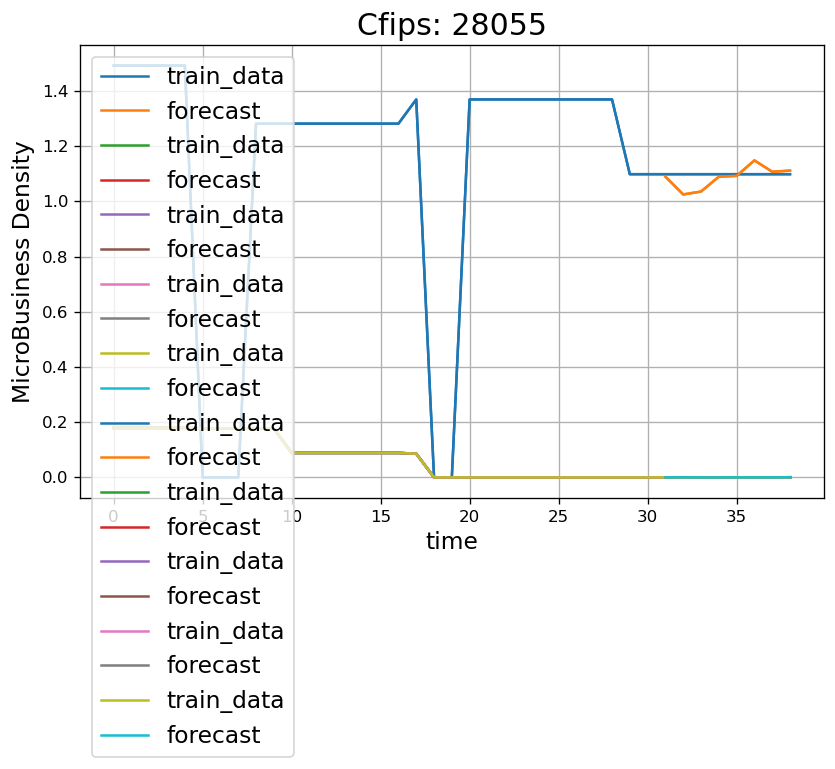

In [99]:
small_IDS = train.sort_values('active').cfips[:10]

HORIZON = 8
WINDOW = 9

for cfips in small_IDS:
    c = cfips
    df = train[train.cfips == c].reset_index()[['cfips', 'active', 'microbusiness_density', ]]
    # add window columns
    for i in range(WINDOW):
        df[f'microbusiness_density+{i+1}'] = df['microbusiness_density'].shift(periods=i+1)

    # create sequenced label
    windows, labels = make_windows(df['microbusiness_density'].values, window_size=(WINDOW-HORIZON)+1, horizon=HORIZON)

    df = df[WINDOW:]

    df = df.reset_index().drop('index', axis=1)

    # Set microbusiness_density sequence as label, and rest of the data as feature
    X = df.drop(['cfips', 'microbusiness_density'], axis=1)
    Y = labels

    # Scale feature
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    train_data, test_data, train_labels, test_labels = make_train_test_split(X, Y, split_size=6)

    tf.random.set_seed(42)

    model = tf.keras.Sequential([
                    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                    layers.LSTM(128, activation="relu", return_sequences=True),
                    layers.LSTM(128, activation="relu", return_sequences=True),
                    layers.LSTM(128, activation="relu"),
                    layers.Dense(8)
                ], name=f'lstm_model')

    model.compile(loss='mae', 
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['mae', 'mse'])

    model.fit(x=train_data, 
              y=train_labels, 
              epochs=500,
              batch_size=256, verbose=0)

    preds = make_preds(model, test_data)
    results = evaluate_preds(test_labels, preds)

    print(results)

    plot_time_series(c, np.arange(39).reshape((-1, 1)), train[train.cfips == c]['microbusiness_density'], label='train_data')
    plot_time_series(c, np.arange(31, 39).reshape((-1, 1)), preds[-1], label='forecast')

# Next Step:

* get the result mape and put on dataframe.
* same_value result as I did before. 
* get better result then I will do the same thing as I did before. 
* create function in helper function, so I can use multiprocess to get the results. 
* try add census data.

In [23]:
train = pd.read_csv('train.csv')

In [29]:
%%time
if __name__ == '__main__':
    HORIZON = 8
    WINDOW_SIZE = 9

    train = pd.read_csv('train.csv')
    IDS = train.cfips.unique()

    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(31,39).reshape((-1,1))
    #random_ids = random.sample(list(IDS), 10)
    random_ids = IDS[:10]
    window_size = WINDOW_SIZE
    horizon = HORIZON
    epoch = 500
    split_size = 6
    
    cfips_list = []
    mapes = []
    density_values = []
    active_size = []
    forecasts = []

    pool = mp.Pool(16)

    func = partial(train_get_results_multi_variables, train, window_size, horizon, epoch, split_size)
    results = pool.map(func, random_ids)
    pool.close()
    pool.join()
    
    # Create DataFrame
    for i in range(len(results)):
        c = results[i][0]
        cfips_list.append(c)
        last_density = results[i][1]
        density_values.append(last_density)
        last_active = results[i][2]
        active_size.append(last_active)
        mape = results[i][3]
        mapes.append(mape)
        preds = results[i][4]
        x = np.array(preds).reshape((-1))
        preds = x.astype(np.float64)
        forecasts.append(preds)
    
    result_df = pd.DataFrame({'Country': cfips_list,
                             'MAPE': mapes,
                             "Density": density_values,
                             'Active': active_size,
                             'forecast': forecasts})

CPU times: total: 266 ms
Wall time: 33.7 s


In [30]:
result_df

,Country,MAPE,Density,Active,forecast
0,1001,0.732748,3.334431,1417,"[3.222472667694092, 3.2164089679718018, 3.2347..."
1,1003,0.747286,7.823300,13401,"[7.828029155731201, 7.833648204803467, 7.83948..."
2,1005,1.273616,1.206827,239,"[1.145735502243042, 1.145476222038269, 1.16040..."
3,1007,9.315642,1.236650,220,"[1.1020089387893677, 1.0923653841018677, 1.088..."
4,1009,0.766072,1.777708,789,"[1.7370038032531738, 1.743842363357544, 1.7520..."
5,1011,4.382242,0.874082,69,"[0.8530714511871338, 0.8411870002746582, 0.824..."
6,1013,2.639335,1.944535,298,"[1.9350241422653198, 1.9424179792404175, 1.946..."
7,1015,2.105894,2.706717,2424,"[2.6211307048797607, 2.627647638320923, 2.6218..."
8,1017,6.220597,1.438767,381,"[1.4936749935150146, 1.4972578287124634, 1.499..."
9,1019,2.760927,1.326550,279,"[1.2481770515441895, 1.2439470291137695, 1.253..."


In [34]:
result_df.loc[result_df.Country == 1001]["forecast"][0]

array([3.22247267, 3.21640897, 3.23477602, 3.27504683, 3.32651687,
       3.34727144, 3.3662653 , 3.37387347, 3.27166557, 3.26684642,
       3.2791853 , 3.29856348, 3.33631063, 3.35596085, 3.38059235,
       3.39626598, 3.31165028, 3.30770564, 3.31478381, 3.31609869,
       3.34183836, 3.36048603, 3.39034414, 3.41295624, 3.33110142,
       3.32661939, 3.33422971, 3.33611917, 3.3626554 , 3.38131094,
       3.41121006, 3.43426847, 3.34571314, 3.339679  , 3.35068059,
       3.36258221, 3.39600277, 3.41546726, 3.44250536, 3.46314096,
       3.34542775, 3.3380444 , 3.35330129, 3.37871742, 3.42133403,
       3.44150639, 3.4648242 , 3.4812417 ])

## Same value as last number the prediction:

Get the result then compare with LSTM model